In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


In [139]:
path = "C:\\Users\\ajord\\Documents\\Renewables.csv"
df = pd.read_csv(path, delimiter=",")
df.head(5)

,year,co2,nuclear_generation,hydroelectricity_generation,solar_generation,wind_generation,geothermal_biomass_other_generation
0,1965.0,11189.7,25.5,923.2,0.0,0.0,18.0
1,1966.0,11694.9,34.4,983.8,0.0,0.0,19.8
2,1967.0,12055.5,41.0,1005.7,0.0,0.0,20.0
3,1968.0,12701.5,52.1,1059.3,0.0,0.0,22.1
4,1969.0,13483.7,61.8,1121.7,0.0,0.0,23.3


In [140]:
df = df.dropna()
df.index =  pd.to_datetime(df.year, format= '%Y')
df = df.drop('year', axis=1)
df.head()

,co2,nuclear_generation,hydroelectricity_generation,solar_generation,wind_generation,geothermal_biomass_other_generation
year,,,,,,
1965-01-01,11189.7,25.5,923.2,0.0,0.0,18.0
1966-01-01,11694.9,34.4,983.8,0.0,0.0,19.8
1967-01-01,12055.5,41.0,1005.7,0.0,0.0,20.0
1968-01-01,12701.5,52.1,1059.3,0.0,0.0,22.1
1969-01-01,13483.7,61.8,1121.7,0.0,0.0,23.3


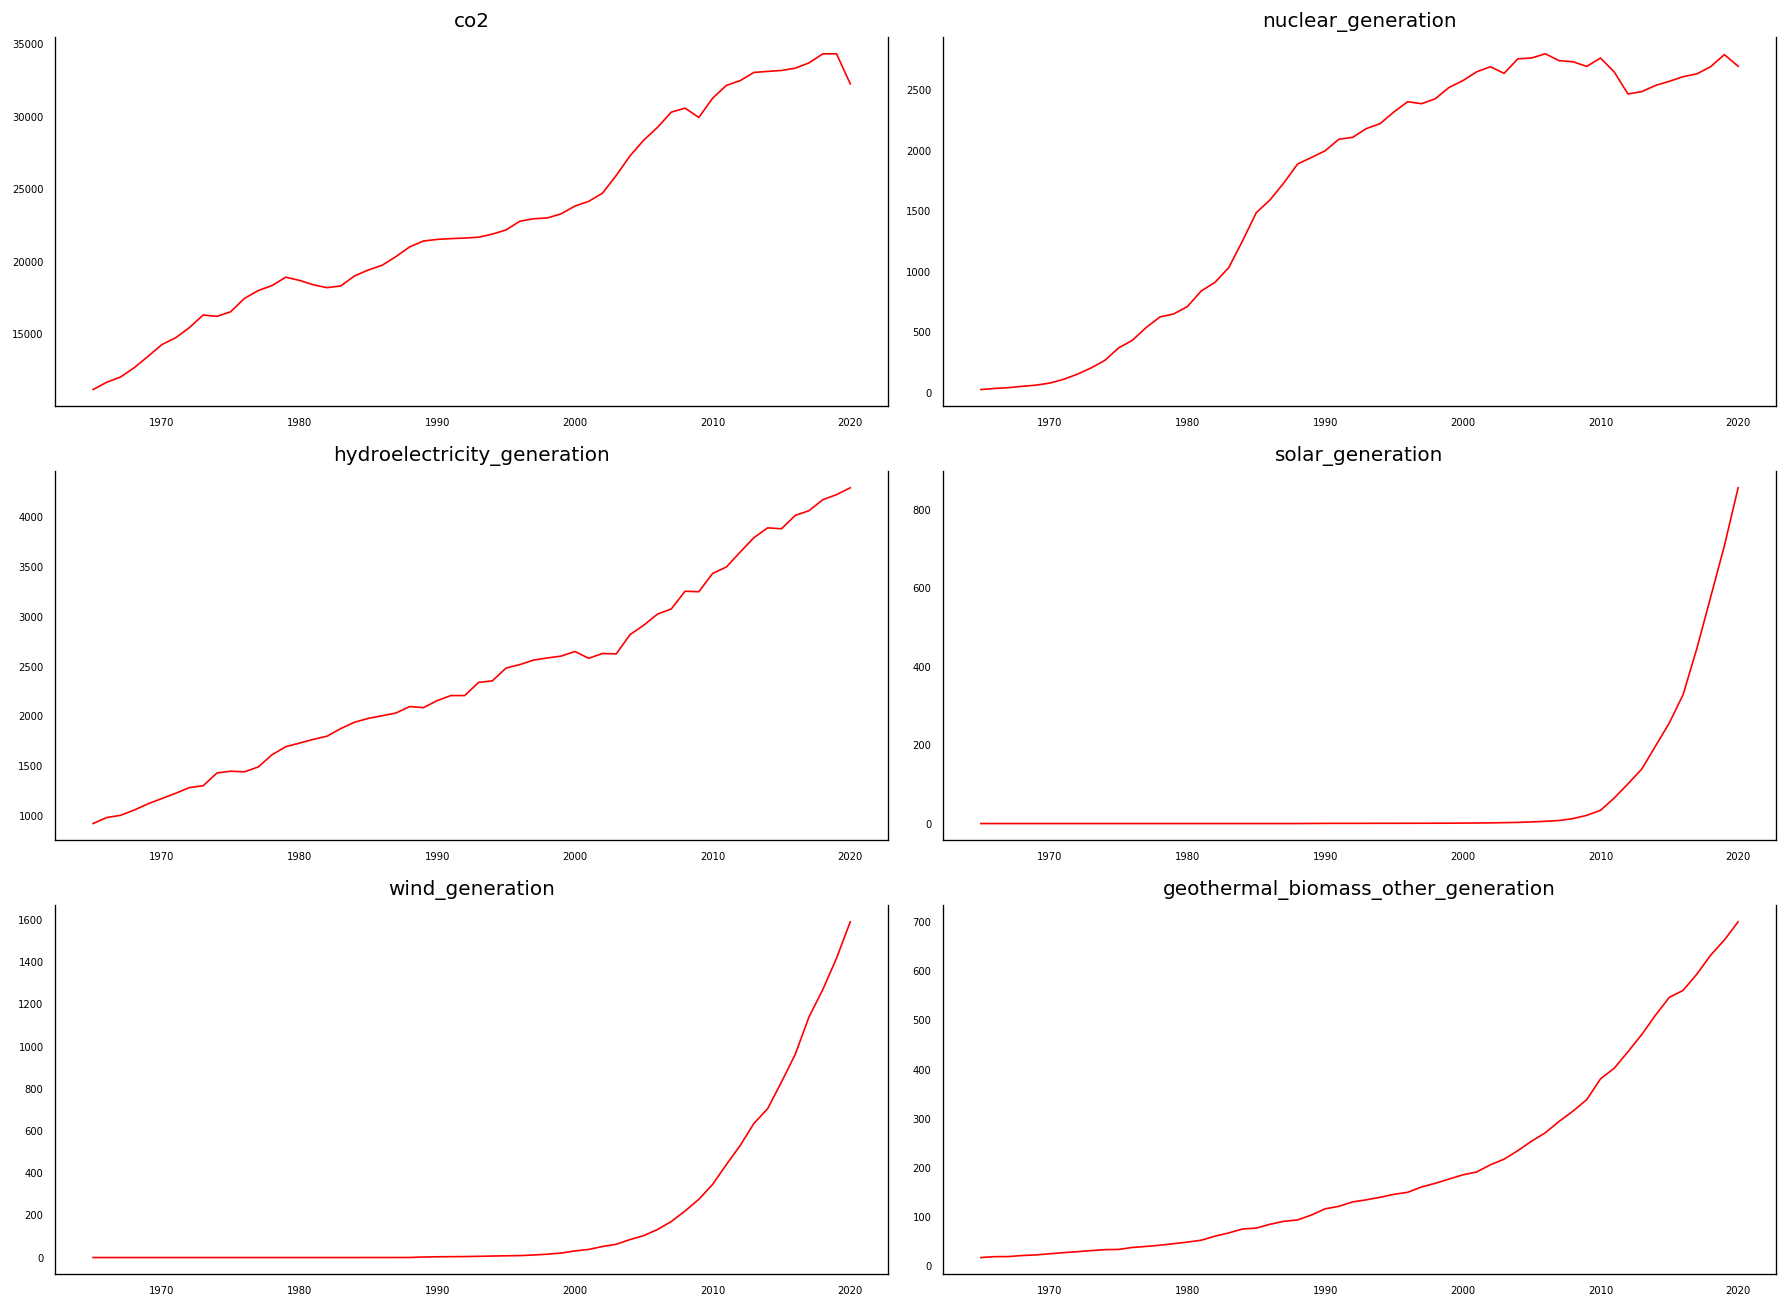

In [141]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(15,11))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [142]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)     

,co2_x,nuclear_generation_x,hydroelectricity_generation_x,solar_generation_x,wind_generation_x,geothermal_biomass_other_generation_x
co2_y,1.0000,0.0000,0.0000,0.0,0.0,0.0000
nuclear_generation_y,0.0001,1.0000,0.0000,0.0,0.0,0.0018
hydroelectricity_generation_y,0.0000,0.0008,1.0000,0.0,0.0,0.0000
solar_generation_y,0.0000,0.0000,0.0000,1.0,0.0,0.0000
wind_generation_y,0.0000,0.0000,0.0000,0.0,1.0,0.0000
geothermal_biomass_other_generation_y,0.0004,0.0000,0.0051,0.0,0.0,1.0000


In [143]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
co2    ::  369.41    > 83.9383   =>   True
nuclear_generation ::  224.16    > 60.0627   =>   True
hydroelectricity_generation ::  139.79    > 40.1749   =>   True
solar_generation ::  70.95     > 24.2761   =>   True
wind_generation ::  23.68     > 12.3212   =>   True
geothermal_biomass_other_generation ::  6.31      > 4.1296    =>   True


In [144]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

(52, 6)
(4, 6)


In [145]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  


for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')  

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2298
 No. Lags Chosen       = 1
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.9349. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "nuclear_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5688
 No. Lags Chosen       = 1
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.4992. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "hydroelectricity_generation" 
    ----------------------------------------------

In [152]:
df_differenced = np.log(df_train).diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')  

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.7407
 No. Lags Chosen       = 0
 Critical value 1%     = -3.646
 Critical value 5%     = -2.954
 Critical value 10%    = -2.616
 => P-Value = 0.0036. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "nuclear_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6339
 No. Lags Chosen       = 0
 Critical value 1%     = -3.646
 Critical value 5%     = -2.954
 Critical value 10%    = -2.616
 => P-Value = 0.0862. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "hydroelectricity_generation" 
    -----------------------------------------------
 Null Hypothesis: Da

C:\Users\ajord\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


LinAlgError: SVD did not converge

In [147]:
df_differenced = df_differenced.diff().dropna()

for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "co2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6207
 No. Lags Chosen       = 1
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "nuclear_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1893
 No. Lags Chosen       = 1
 Critical value 1%     = -3.575
 Critical value 5%     = -2.924
 Critical value 10%    = -2.6
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "hydroelectricity_generation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

In [148]:
# df_differenced = df_differenced.diff().dropna()

# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [150]:
model = VAR(df_differenced.dropna())
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  38.103881785944345
BIC :  39.72544204146774
FPE :  3.576293820354405e+16
HQIC:  38.71909948503844 

Lag Order = 2
AIC :  37.03740580214286
BIC :  40.07810744486818
FPE :  1.3220705820258182e+16
HQIC:  38.186491394448396 

Lag Order = 3
AIC :  35.14157483406764
BIC :  39.629166889279276
FPE :  2450852689354097.5
HQIC:  36.83028587094125 

Lag Order = 4
AIC :  32.68371474173502
BIC :  38.64667581724294
FPE :  343744665831414.2
HQIC:  34.91747569932339 

Lag Order = 5
AIC :  31.904489295787627
BIC :  39.37202758683828
FPE :  471942698729409.8
HQIC:  34.68831259374188 

Lag Order = 6
AIC :  26.917863079886843
BIC :  35.91991077829262
FPE :  48772513525722.164
HQIC:  30.25625634090879 

Lag Order = 7


C:\Users\ajord\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\ajord\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:716: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
C:\Users\ajord\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:1379: RuntimeWarning: invalid value encountered in multiply
  return self.sigma_u * self.df_resid / self.nobs


ValueError: array must not contain infs or NaNs

In [ ]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Oct, 2021
Time:                     22:59:57
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    40.5184
Nobs:                     45.0000    HQIC:                   36.7412
Log likelihood:          -1009.28    FPE:                2.24190e+15
AIC:                      34.4962    Det(Omega_mle):     1.58235e+14
--------------------------------------------------------------------
Results for equation co2
                                            coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------
const                                         18.976040        72.258522            0.263           0.793
L1.co2                                        -0.881470         0.19

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

co2 : 1.59
nuclear_generation : 2.25
hydroelectricity_generation : 2.22
solar_generation : 1.78
wind_generation : 1.84
geothermal_biomass_other_generation : 2.14


In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 785.3   ,  267.7   ,  -86.    ,   -2.6661,   18.4   ,  -10.7   ],
       [-733.4   , -170.4   ,  -45.2   ,   19.2399,  -49.3   ,    3.2   ],
       [ 493.6   ,  -47.9   ,  -59.7   ,  -21.2706,   89.9   ,   -7.8   ],
       [  94.5   ,   20.8   ,  250.4   ,   13.6606,  -50.1   ,  -18.7   ]])

In [ ]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,co2_2d,nuclear_generation_2d,hydroelectricity_generation_2d,solar_generation_2d,wind_generation_2d,geothermal_biomass_other_generation_2d
year,,,,,,
2017-01-01,-4905.182354,133.891933,-429.912613,19.041497,3.718517,18.154618
2018-01-01,3689.747083,-636.697992,-517.698327,-70.644372,-73.386074,27.965194
2019-01-01,13054.922521,2212.044814,2726.744008,76.511206,173.392809,8.896120
2020-01-01,-22231.616371,-3866.164078,-3766.284554,44.445397,-144.822601,-130.575808


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results

KeyError: 'co2_1d'